In [25]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, GRU, Dense, Input, Conv1D, MaxPooling1D, Flatten, Bidirectional, ConvLSTM2D, BatchNormalization, Attention, Add
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [26]:
# Load the dataset
df = pd.read_csv('/kaggle/input/gait-conc-dataset/Abhay.csv')

In [27]:
# Check for NaN or infinite values and handle them
df = df.ffill().bfill()  # Forward fill then backward fill for any remaining NaNs
df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values with NaNs
df.dropna(inplace=True) 

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

print(np.min(data_scaled), np.max(data_scaled))  # Check the range of scaled data


0.0 1.0000000000000002


In [28]:
# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length]
        sequences.append((seq, target))
    return sequences

seq_length = 10
sequences = create_sequences(data_scaled, seq_length)

In [32]:
X = np.array([seq[0] for seq in sequences])
y = np.array([seq[1] for seq in sequences])

print(X.shape, y.shape)  # Check the shapes of X and y
print(np.isnan(X).sum(), np.isnan(y).sum())   in sequences
print(np.isinf(X).sum(), np.isinf(y).sum())   in sequences

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape the data for ConvLSTM
X_train_conv = X_train.reshape((X_train.shape[0], X_train.shape[1], 1, 1, X_train.shape[2]))
X_test_conv = X_test.reshape((X_test.shape[0], X_test.shape[1], 1, 1, X_test.shape[2]))

input_features = X_train.shape[2]
print(f'Number of features provided to the model: {input_features}')
output_features = y_train.shape[1]
print(f'Number of features being predicted by the model: {output_features}')

(12042, 10, 36) (12042, 36)
0 0
0 0
Number of features provided to the model: 36
Number of features being predicted by the model: 36


In [33]:
# # # Build LSTM model
# # model = Sequential()
# # model.add(Input(shape=(seq_length, X.shape[2])))
# # model.add(LSTM(50, return_sequences=True))
# # model.add(LSTM(50))
# # model.add(Dense(y.shape[1]))

# # model.compile(optimizer='adam', loss='mse')
# # model.summary()
# # Function to create LSTM model
# def create_lstm_model(input_shape):
#     model = Sequential()
#     model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=input_shape))
#     model.add(LSTM(50, activation='tanh'))
#     model.add(Dense(input_shape[-1]))
#     optimizer = Adam(learning_rate=0.001, clipnorm=1.0)  # Gradient clipping
#     model.compile(optimizer=optimizer, loss='mse')
#     return model

# input_shape = (X_train.shape[1], X_train.shape[2])
# model = create_lstm_model(input_shape)
# model.summary()

# Function to create the LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, activation='tanh'))
    model.add(Dense(input_shape[-1]))
    model.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss='mse')
    return model

# 1D CNN model
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(input_shape[-1]))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Hybrid CNN-LSTM model
def create_cnn_lstm_model(input_shape):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(50, activation='tanh', return_sequences=False))
    model.add(Dense(input_shape[-1]))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Bidirectional LSTM model
def create_bidirectional_lstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='tanh', return_sequences=True), input_shape=input_shape))
    model.add(Bidirectional(LSTM(50, activation='tanh')))
    model.add(Dense(input_shape[-1]))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# GRU model
def create_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(50, activation='tanh', return_sequences=True, input_shape=input_shape))
    model.add(GRU(50, activation='tanh'))
    model.add(Dense(input_shape[-1]))
    model.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss='mse')
    return model

# Corrected ConvLSTM model
def create_convlstm_model(input_shape):
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1, 1), activation='relu',
                         input_shape=(input_shape[0], 1, 1, input_shape[1]),
                         return_sequences=True))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(input_shape[-1]))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model
# LSTM with Attention model
def create_lstm_attention_model(input_shape):
    inputs = Input(shape=input_shape)
    lstm_out = LSTM(50, return_sequences=True)(inputs)
    attention_out = Attention()([lstm_out, lstm_out])
    add_out = Add()([lstm_out, attention_out])
    lstm_out2 = LSTM(50)(add_out)
    outputs = Dense(input_shape[-1])(lstm_out2)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss='mse')
    return model



In [34]:
# Prepare input shape
input_shape = (X_train.shape[1], X_train.shape[2])

# Initialize models
lstm_model = create_lstm_model(input_shape)
lstm_model.summary()
cnn_model = create_cnn_model(input_shape)
cnn_model.summary()
cnn_lstm_model = create_cnn_lstm_model(input_shape)
cnn_lstm_model.summary()
bidirectional_lstm_model = create_bidirectional_lstm_model(input_shape)
bidirectional_lstm_model.summary()
gru_model = create_gru_model(input_shape)
gru_model.summary()
convlstm_model = create_convlstm_model(input_shape)
convlstm_model.summary()
lstm_attention_model = create_lstm_attention_model(input_shape)
lstm_attention_model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 10, 50)         │        17,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 36)             │         1,836 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,436 (154.05 KB)

 Trainable params: 39,436 (154.05 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 8, 64)          │         6,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 50)             │        12,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 36)             │         1,836 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,662 (84.62 KB)

 Trainable params: 21,662 (84.62 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)               │ (None, 8, 64)          │         6,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 36)             │         1,836 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,812 (124.27 KB)

 Trainable params: 31,812 (124.27 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ (None, 10, 100)        │        34,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 100)            │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 36)             │         3,636 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,836 (386.08 KB)

 Trainable params: 98,836 (386.08 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 10, 50)         │        13,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 36)             │         1,836 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,336 (118.50 KB)

 Trainable params: 30,336 (118.50 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 10, 1, 1, 64)   │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 1, 1, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 36)             │        23,076 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,188 (192.14 KB)

 Trainable params: 49,060 (191.64 KB)

 Non-trainable params: 128 (512.00 B)

Model: "functional_73"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 10, 36)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_20 (LSTM)      │ (None, 10, 50)    │     17,400 │ input_layer_20[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 10, 50)    │          0 │ lstm_20[0][0],    │
│ (Attention)         │                   │            │ lstm_20[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 50)    │          0 │ lstm_20[0][0],    │
│                     │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_21 (LSTM)      │ (None, 50)        │     20,200 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 36)        │      1,836 │ lstm_21[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 39,436 (154.05 KB)

 Trainable params: 39,436 (154.05 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
lstm_history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0353 - val_loss: 3.4422e-04
Epoch 2/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0030 - val_loss: 2.1589e-04
Epoch 3/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0020 - val_loss: 1.6953e-04
Epoch 4/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0016 - val_loss: 2.0855e-04
Epoch 5/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0014 - val_loss: 1.6158e-04
Epoch 6/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011 - val_loss: 8.5778e-05
Epoch 7/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.4842e-04 - val_loss: 1.2069e-04
Epoch 8/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.9401e-04 - val_loss: 1.1470e-04
Epoch 9/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.3423e-04 - val_loss: 7.9993e-05
Epoch 10/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.1657e-04 - val_loss: 8.7662e-05
Epoch 11/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.7970e-04 - val_loss:

In [36]:
cnn_history = cnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0592 - val_loss: 5.8065e-04
Epoch 2/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - val_loss: 1.9245e-04
Epoch 3/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 - val_loss: 1.5573e-04
Epoch 4/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020 - val_loss: 1.5909e-04
Epoch 5/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017 - val_loss: 1.5770e-04
Epoch 6/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 - val_loss: 1.2672e-04
Epoch 7/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - val_loss: 1.4220e-04
Epoch 8/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - val_loss: 1.1409e-04
Epoch 9/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - val_loss: 1.4103e-04
Epoch 10/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - val_loss: 1.2274e-04
Epoch 11/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.9850e-04 - val_loss: 9.9983e-05
Epoc

In [37]:
cnn_lstm_history = cnn_lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0496 - val_loss: 2.7280e-04
Epoch 2/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0030 - val_loss: 2.0209e-04
Epoch 3/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0020 - val_loss: 1.3194e-04
Epoch 4/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015 - val_loss: 1.3900e-04
Epoch 5/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013 - val_loss: 1.2651e-04
Epoch 6/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012 - val_loss: 9.6563e-05
Epoch 7/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0010 - val_loss: 1.0938e-04
Epoch 8/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.5809e-04 - val_loss: 9.6439e-05
Epoch 9/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.4430e-04 - val_loss: 1.0893e-04
Epoch 10/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.0047e-04 - val_loss: 7.4185e-05
Epoch 11/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.1991e-04 - val_loss: 1.1

In [38]:
bidirectional_lstm_history = bidirectional_lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0234 - val_loss: 2.5787e-04
Epoch 2/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0017 - val_loss: 2.4087e-04
Epoch 3/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0012 - val_loss: 1.7080e-04
Epoch 4/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.9745e-04 - val_loss: 1.2097e-04
Epoch 5/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.6291e-04 - val_loss: 9.8123e-05
Epoch 6/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.2375e-04 - val_loss: 1.1020e-04
Epoch 7/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.9684e-04 - val_loss: 1.5359e-04
Epoch 8/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.6151e-04 - val_loss: 9.3065e-05
Epoch 9/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.9379e-04 - val_loss: 7.3818e-05
Epoch 10/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.4325e-04 - val_loss: 4.1760e-05
Epoch 11/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.3929e-0

In [39]:
gru_history = gru_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0309 - val_loss: 2.7755e-04
Epoch 2/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0024 - val_loss: 1.1003e-04
Epoch 3/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0014 - val_loss: 7.5431e-05
Epoch 4/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011 - val_loss: 7.6350e-05
Epoch 5/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.5852e-04 - val_loss: 6.2705e-05
Epoch 6/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.6734e-04 - val_loss: 6.5897e-05
Epoch 7/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.0912e-04 - val_loss: 4.6443e-05
Epoch 8/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.3560e-04 - val_loss: 5.1431e-05
Epoch 9/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.7023e-04 - val_loss: 4.8520e-05
Epoch 10/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1897e-04 - val_loss: 3.6809e-05
Epoch 11/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.9674e-04 - v

In [40]:
convlstm_history = convlstm_model.fit(X_train_conv, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0930 - val_loss: 0.0855
Epoch 2/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0026 - val_loss: 0.0161
Epoch 3/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 4/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 5/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 6/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 7/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 8/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 9/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 10/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0010 - val_loss: 0.0044
Epoch 11/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 12/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/ste

In [41]:
lstm_attention_history = lstm_attention_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0338 - val_loss: 3.4195e-04
Epoch 2/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0028 - val_loss: 1.8487e-04
Epoch 3/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0017 - val_loss: 1.4043e-04
Epoch 4/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0014 - val_loss: 1.4224e-04
Epoch 5/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0012 - val_loss: 9.9421e-05
Epoch 6/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011 - val_loss: 1.1538e-04
Epoch 7/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.9397e-04 - val_loss: 1.4583e-04
Epoch 8/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.2721e-04 - val_loss: 5.0436e-05
Epoch 9/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.2753e-04 - val_loss: 6.9063e-05
Epoch 10/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 5.4626e-04 - val_loss: 1.5595e-04
Epoch 11/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.2027e-04 - val_loss:

In [42]:
# # Train the model
# model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


In [57]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# # Make predictions
# predictions = model.predict(X_test)

# # Inverse transform the predictions
# predictions_inverse = scaler.inverse_transform(predictions)
# mse = mean_squared_error(y_test, predictions)
# mae = mean_absolute_error(y_test, predictions)
# print(f'Mean Squared Error: {mse}')
# print(f'Mean Absolute Error: {mae}')
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Evaluate models
def evaluate_model(model, X_test, y_test, scaler, model_name):
    predictions = model.predict(X_test)
    predictions_inverse = scaler.inverse_transform(predictions)
#     print(X_test.shape)
#     print(predictions.shape)
#     print(predictions_inverse.shape)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    print(f'{model_name} - Mean Squared Error: {mse}')
    print(f'{model_name} - Mean Absolute Error: {mae}')
    return predictions_inverse

# Plot results
def plot_predictions(y_test_inverse, predictions_inverse, feature_index, model_name):
    plt.figure(figsize=(14, 7))
    plt.plot(y_test_inverse[:, feature_index], label='True Values')
    plt.plot(predictions_inverse[:, feature_index], label=f'{model_name} Predictions')
    plt.xlabel('Time')
    plt.ylabel('X (m/s2)_LK')
    plt.title(f'True Values vs {model_name} Predictions for X (m/s2)_LK')
    plt.legend()
    plt.show()
    
# Inverse transform y_test
y_test_inverse = scaler.inverse_transform(y_test)

In [58]:
# Evaluate and plot for each model
lstm_predictions = evaluate_model(lstm_model, X_test, y_test, scaler, 'LSTM')
cnn_predictions = evaluate_model(cnn_model, X_test, y_test, scaler, '1D CNN')
cnn_lstm_predictions = evaluate_model(cnn_lstm_model, X_test, y_test, scaler, 'Hybrid CNN-LSTM')
bidirectional_lstm_predictions = evaluate_model(bidirectional_lstm_model, X_test, y_test, scaler, 'Bidirectional LSTM')
gru_predictions = evaluate_model(gru_model, X_test, y_test, scaler, 'GRU')
convlstm_predictions = evaluate_model(convlstm_model, X_test_conv, y_test, scaler, 'ConvLSTM')
lstm_attention_predictions = evaluate_model(lstm_attention_model, X_test, y_test, scaler, 'LSTM with Attention')


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
LSTM - Mean Squared Error: 3.1405249641307065e-05
LSTM - Mean Absolute Error: 0.004437123997141752
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1D CNN - Mean Squared Error: 4.344663726845359e-05
1D CNN - Mean Absolute Error: 0.005199052174806574
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Hybrid CNN-LSTM - Mean Squared Error: 2.6689270443295503e-05
Hybrid CNN-LSTM - Mean Absolute Error: 0.0037198775343833443
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Bidirectional LSTM - Mean Squared Error: 2.5774426227626508e-05
Bidirectional LSTM - Mean Absolute Error: 0.003692040344187195
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
GRU - Mean Squared Error: 1.6891439992385724e-05
GRU - Mean Absolute Error: 0.0032515169203701797
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
ConvLSTM - Mean Squared Error: 0.00022436553322627414
ConvLSTM - Mean Absolute Error: 0.012074368223846107
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
LSTM with Attention - Mean Squared Error: 3.1925159004136304e-05
LSTM wi

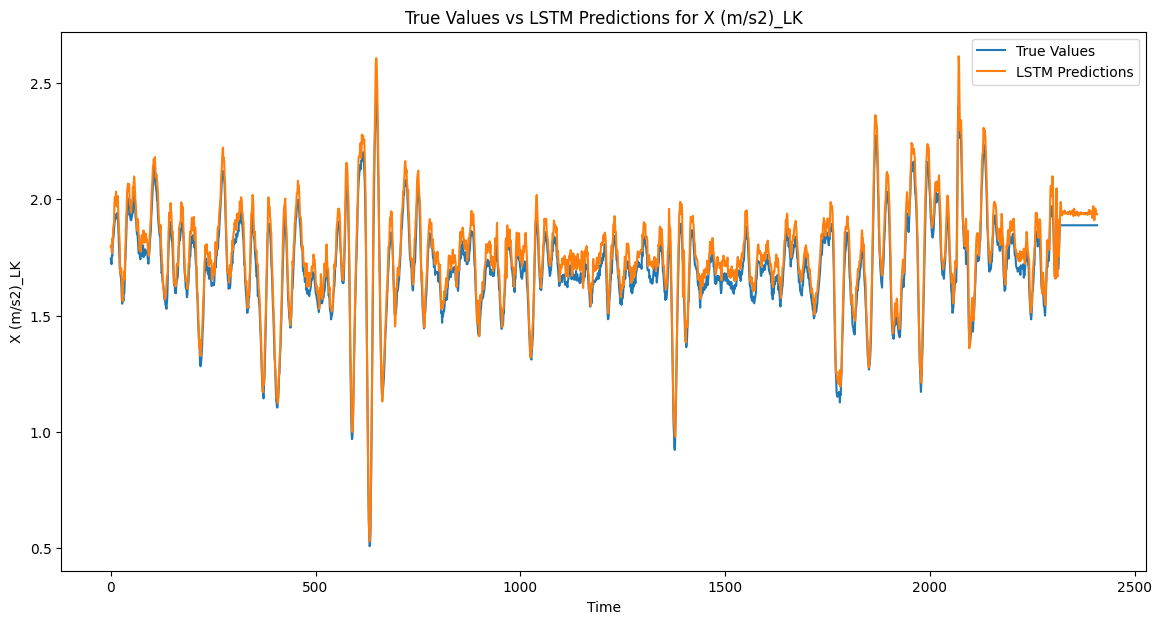

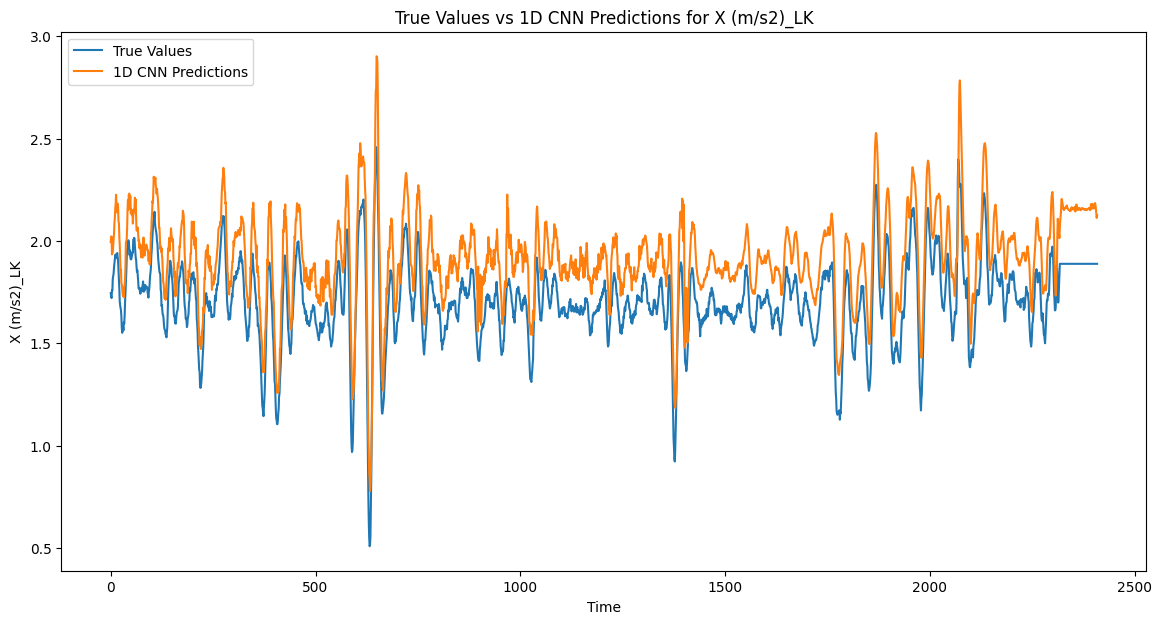

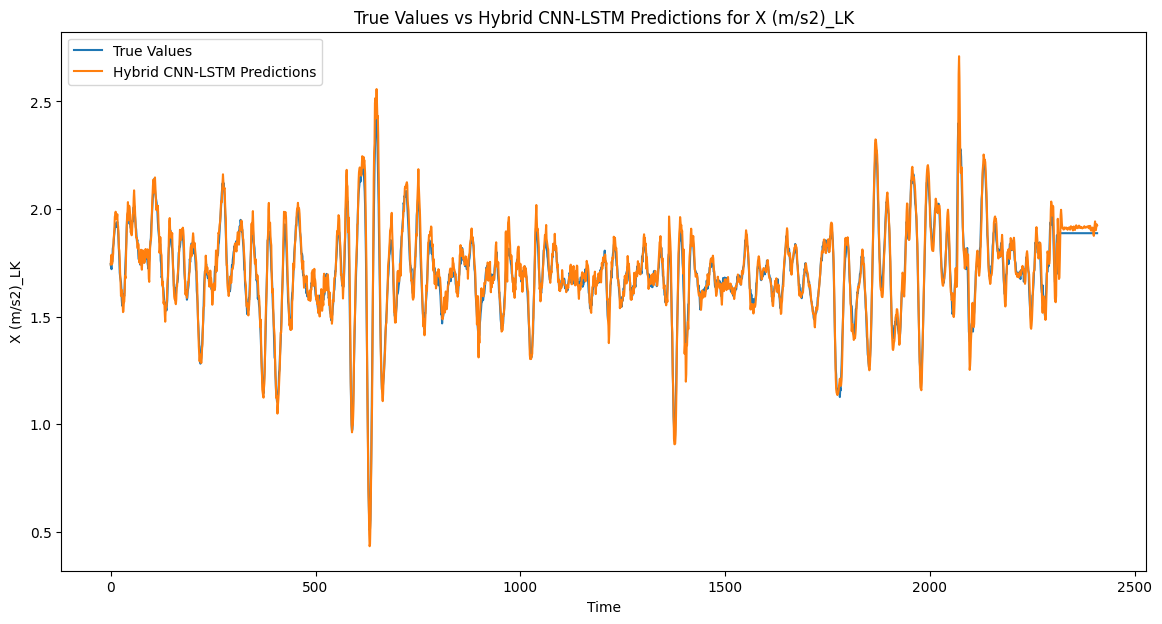

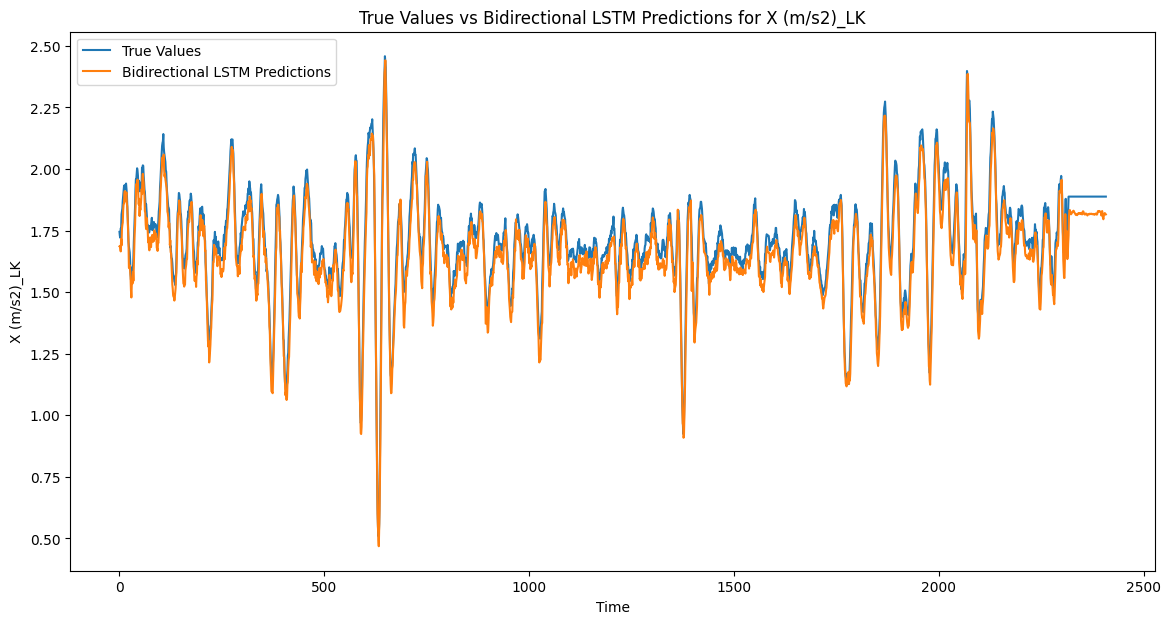

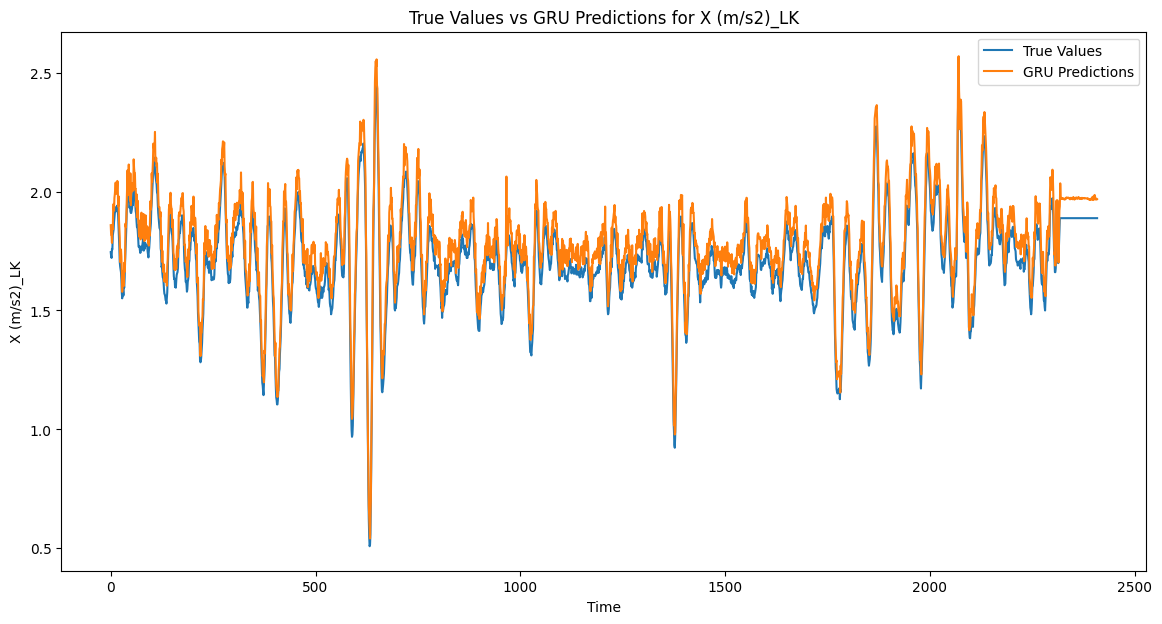

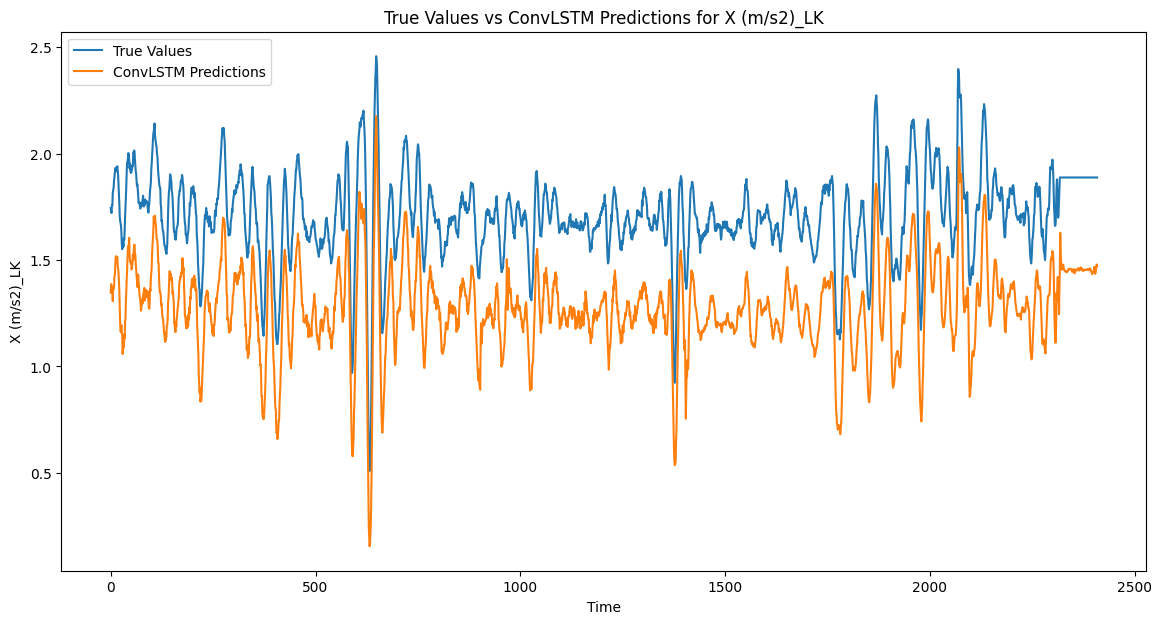

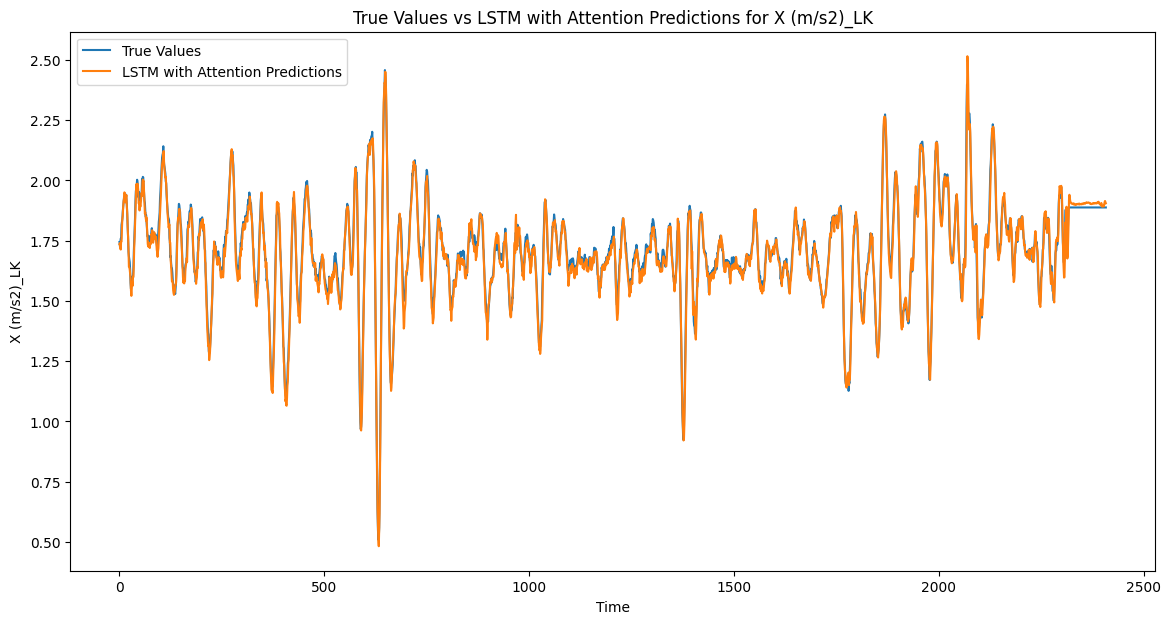

In [59]:
# Plot predictions
feature_index = 0  # Choose the feature to plot
plot_predictions(y_test_inverse, lstm_predictions, feature_index, 'LSTM')
plot_predictions(y_test_inverse, cnn_predictions, feature_index, '1D CNN')
plot_predictions(y_test_inverse, cnn_lstm_predictions, feature_index, 'Hybrid CNN-LSTM')
plot_predictions(y_test_inverse, bidirectional_lstm_predictions, feature_index, 'Bidirectional LSTM')
plot_predictions(y_test_inverse, gru_predictions, feature_index, 'GRU')
plot_predictions(y_test_inverse, convlstm_predictions, feature_index, 'ConvLSTM')
plot_predictions(y_test_inverse, lstm_attention_predictions, feature_index, 'LSTM with Attention')


In [46]:
# Check the shapes of y_test and predictions
# print("Shape of y_test:", y_test.shape)
# print("Shape of predictions:", predictions.shape)

In [47]:
# import matplotlib.pyplot as plt

# # Assuming predictions and y_test are inverse transformed already
# # If not, inverse transform them
# y_test_inverse = scaler.inverse_transform(y_test)

# # Select a feature to plot (e.g., the first feature)
# feature_index = 0

# # Plot the true values
# plt.figure(figsize=(14, 7))
# plt.plot(y_test_inverse[:, feature_index], label='True Values')
# # Plot the predicted values
# plt.plot(predictions_inverse[:, feature_index], label='Predictions')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title('True Values vs Predictions')
# plt.legend()
# plt.show()
